# Optimize the design of the transmon pocket

To keep the structure roughly the same, we change the width of the metal pad in the transmon pocket. Intuitively, the wider the transmon pocket, the larger the capacitance would be. To increase the qubit frequency, we need to increase the capacitance.

## Steps
1. Construct the function that takes in padwidth and return a capacitance between ground and the metal pad
2. Function that takes in frequency and spit out desired capacitance
3. Optimize and find the desired design

In [68]:

import astropy.units as u
import astropy.constants as c
import numpy as np
import matplotlib.pyplot as plt

from scipy import optimize
from scipy import stats

%matplotlib inline

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
#This imports the necessary path to draw the single pad transmon design. 
import sys
sys.path.append('Customized_Components')
from single_pad_transmon_pocket import TransmonPocket_Single

import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [4]:
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings

In [5]:
design = designs.DesignPlanar()
gui = MetalGUI(design)

### Construct a single transmon pad to test the code

In [6]:
design.overwrite_enabled = True #This makes it possible to edit the designs later on. 

design.delete_all_components()

options = dict(pad_width = '200um',
pocket_width = '300um',
pad_pocket_distance_top = '60um',
pos_x = '0',
pad_height = '200um',
pos_y = '0',
connection_pads = dict(
    a = dict(loc_W  = 1, 
             loc_H =  1, 
             pad_gap = '10um',
             pad_height = '20um',
             pad_width = '100um',
             pad_cpw_extent =  '10um',
             pocket_rise = '0um',
             cpw_extend = '0um')))

q1 = TransmonPocket_Single(design,'Q1',options = options)

gui.rebuild()
gui.zoom_on_components(['Q1'])

In [7]:
from qiskit_metal.analyses.quantization import LOManalysis
c1 = LOManalysis(design, "q3d")

In [8]:
c1.sim.setup.min_passes  = 1
c1.sim.setup.max_passes = 5
print(c1.sim.setup)

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'freq_ghz': 5.0, 'save_fields': False, 'enabled': True, 'max_passes': 5, 'min_passes': 1, 'min_converged_passes': 2, 'percent_error': 0.5, 'percent_refinement': 30, 'auto_increase_solution_order': True, 'solution_order': 'High', 'solver_type': 'Iterative'}


In [9]:
c1.sim.run(components=['Q1'], open_terminations=[('Q1', 'a')])#, ('Q1', 'bus1'), ('Q1', 'bus2')])
c1.sim.capacitance_matrix 

c1.sim._get_results_from_renderer()
c_mat = c1.sim.capacitance_matrix

INFO 05:23PM [connect_project]: Connecting to Ansys Desktop API...
INFO 05:23PM [load_ansys_project]: 	Opened Ansys App
INFO 05:23PM [load_ansys_project]: 	Opened Ansys Desktop v2021.2.0
INFO 05:23PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/slab/Documents/Ansoft/
	Project:   Project14
INFO 05:23PM [connect_design]: 	Opened active design
	Design:    readout [Solution type: Eigenmode]
INFO 05:23PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 05:23PM [connect]: 	Connected to project "Project14" and design "readout" 😀 

INFO 05:23PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 05:23PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 05:23PM [analyze]: Analyzing setup Setup
INFO 05:24PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp9y8ir6bt.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, F

In [11]:
c_mat

,a_connector_pad_Q1,ground_main_plane,pad_top_Q1
a_connector_pad_Q1,23.08703,-13.21651,-9.49272
ground_main_plane,-13.21651,122.26453,-67.33210
pad_top_Q1,-9.49272,-67.33210,80.27398


In [12]:
C = c_mat['ground_main_plane']['a_connector_pad_Q1']

In [13]:
C

-13.21651

### Sainity check the general trend of capacitance

This ensures that capacitance of the top pad to ground is a roughly linear funciton. 

In [88]:
def find_Cap(gap):
    if type(gap)== u.quantity.Quantity:
        gap = gap.to(u.um)
    elif type(gap) == np.ndarray:
        gap = gap[0]*u.um
    design.delete_all_components()
    
    width = 300*u.um-2*gap

    options = dict(pad_width = '{}'.format(width),
    pocket_width = '{}'.format(350*u.um),
    pad_pocket_distance_top = '30um',
    pos_x = '0',
    pad_height = '250um',
    jj_length = '30um',
    pos_y = '0',
    connection_pads = dict(
        a = dict(loc_W  = 1, 
                loc_H =  1, 
                pad_gap = '10um',
                pad_height = '15um',
                pad_width = '60um',
                pad_cpw_extent =  '10um',
                pocket_rise = '0um',
                cpw_extend = '0')))

    q1 = TransmonPocket_Single(design,'Q1',options = options)

    gui.rebuild()
    gui.zoom_on_components(['Q1'])
    
    
    c1 = LOManalysis(design, "q3d")
    c1.sim.setup.min_passes  = 5
    c1.sim.setup.max_passes = 10
    
    c1.sim.run(components=['Q1'], open_terminations=[('Q1', 'a')])#, ('Q1', 'bus1'), ('Q1', 'bus2')])
    c1.sim.capacitance_matrix 

    c1.sim._get_results_from_renderer()
    c_mat = c1.sim.capacitance_matrix
    
    print(c_mat)
    
    return(-c_mat['ground_main_plane']['pad_top_Q1'])*u.fF
    

In [89]:
find_Cap(15*u.um)

INFO 11:08PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 11:08PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 11:08PM [analyze]: Analyzing setup Setup
INFO 11:09PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpta1c_nkq.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:09PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpicwv9dii.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 11:09PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpylqeggyf.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 11:09PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpv2bzjk3c.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            18.50010          -13.03592    -5.29844
ground_main_plane            -13.03592          161.70666  -107.81632
pad_top_Q1                    -5.29844         -107.81632   118.18909


<Quantity 107.81632 fF>

In [72]:
gap_min = 15
gap_max = 55

gaps = np.linspace(gap_min*u.um, gap_max*u.um, 30)
result = []
for i, gap in enumerate(gaps):
    result += [find_Cap(gap)]


INFO 09:55PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:55PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:55PM [analyze]: Analyzing setup Setup
INFO 09:56PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpwvdwgmui.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:56PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpq8ollfo9.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:56PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpcaivl6yx.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 09:56PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp2gf06xmy.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            18.40279          -11.27055    -6.96879
ground_main_plane            -11.27055          171.02949  -119.92827
pad_top_Q1                    -6.96879         -119.92827   131.79677


INFO 09:56PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:56PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:56PM [analyze]: Analyzing setup Setup
INFO 09:56PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp0eib50o1.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:56PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpxa3d4mly.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:56PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpr406w5y6.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 09:56PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpy1zgx0il.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            18.59890          -11.42629    -7.00751
ground_main_plane            -11.42629          169.49565  -118.22389
pad_top_Q1                    -7.00751         -118.22389   130.10728


INFO 09:56PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:56PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:56PM [analyze]: Analyzing setup Setup
INFO 09:57PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpvn63twdc.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:57PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp3_7edr4p.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:57PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpq_919awd.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 09:57PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpj_08_n9t.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            18.76095          -11.54270    -7.05172
ground_main_plane            -11.54270          167.90220  -116.49154
pad_top_Q1                    -7.05172         -116.49154   128.39458


INFO 09:57PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:57PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:57PM [analyze]: Analyzing setup Setup
INFO 09:58PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp7dr1864c.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:58PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpx0zrk1ao.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:58PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmptmdc__ug.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 09:58PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp2so6a6ca.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            18.92192          -11.66894    -7.08491
ground_main_plane            -11.66894          166.40431  -114.84387
pad_top_Q1                    -7.08491         -114.84387   126.75469


INFO 09:58PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:58PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:58PM [analyze]: Analyzing setup Setup
INFO 09:59PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpuq_a7gte.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:59PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmphw0pr30n.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 09:59PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpeqv0hhe5.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 09:59PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpyva7p512.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            19.08416          -11.79633    -7.11816
ground_main_plane            -11.79633          164.98830  -113.28025
pad_top_Q1                    -7.11816         -113.28025   125.20070


INFO 09:59PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:59PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:59PM [analyze]: Analyzing setup Setup
INFO 10:00PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpo9dhwccu.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:00PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpiy0i3a96.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:00PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpenzzjvdm.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:00PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp04cuc6lc.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            19.15117          -11.87815    -7.10822
ground_main_plane            -11.87815          163.47377  -111.39181
pad_top_Q1                    -7.10822         -111.39181   123.31328


INFO 10:00PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:00PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:00PM [analyze]: Analyzing setup Setup
INFO 10:01PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp9gmege0v.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:01PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpcc2q7oqa.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:01PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpvcf2ybsz.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:01PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp62qqkl25.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            19.31947          -12.00994    -7.14277
ground_main_plane            -12.00994          162.22709  -110.00032
pad_top_Q1                    -7.14277         -110.00032   121.93291


INFO 10:01PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:01PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:01PM [analyze]: Analyzing setup Setup
INFO 10:01PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpevvna4u5.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:01PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp749bt66a.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:01PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp0cz2vgms.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:01PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp1s6nx4dr.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            19.49263          -12.13092    -7.18692
ground_main_plane            -12.13092          161.08378  -108.85700
pad_top_Q1                    -7.18692         -108.85700   120.76773


INFO 10:01PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:01PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:01PM [analyze]: Analyzing setup Setup
INFO 10:02PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp8zi_nhvb.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:02PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpfha34mvw.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:02PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp_tppu4j4.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:02PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpnlcpak5d.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            19.66852          -12.26774    -7.22369
ground_main_plane            -12.26774          159.87749  -107.49065
pad_top_Q1                    -7.22369         -107.49065   119.41135


INFO 10:02PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:02PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:02PM [analyze]: Analyzing setup Setup
INFO 10:03PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp_badtzb7.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:03PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpw5i3t349.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:03PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpk52wbi_m.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:03PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmppwjenjcs.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            19.82022          -12.39982    -7.24169
ground_main_plane            -12.39982          158.86343  -106.27456
pad_top_Q1                    -7.24169         -106.27456   118.18478


INFO 10:03PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:03PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:03PM [analyze]: Analyzing setup Setup
INFO 10:04PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp1ev58hu5.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:04PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpqtyiwt36.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:04PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp5of6riyr.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:04PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpth5th2a1.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            20.00976          -12.55000    -7.27928
ground_main_plane            -12.55000          157.74593  -105.01773
pad_top_Q1                    -7.27928         -105.01773   116.94048


INFO 10:04PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:04PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:04PM [analyze]: Analyzing setup Setup
INFO 10:04PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp87jk_sgh.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:04PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmptpxkd4v3.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:04PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp2k5vmxy1.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:04PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpgg4ls7nc.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            20.13461          -12.66759    -7.28484
ground_main_plane            -12.66759          156.67378  -103.77109
pad_top_Q1                    -7.28484         -103.77109   115.67407


INFO 10:04PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:04PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:04PM [analyze]: Analyzing setup Setup
INFO 10:05PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp_a48emba.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:05PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpr7lixp5o.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:05PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmplbukw62w.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:05PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpozjs51ni.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            20.34305          -12.83518    -7.32390
ground_main_plane            -12.83518          155.73121  -102.68189
pad_top_Q1                    -7.32390         -102.68189   114.59838


INFO 10:05PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:05PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:05PM [analyze]: Analyzing setup Setup
INFO 10:06PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp1g56okiy.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:06PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp3xfbx0nx.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:06PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmphp7wcxtq.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:06PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmphz5dw8s5.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            20.49156          -12.96530    -7.34084
ground_main_plane            -12.96530          154.75840  -101.57493
pad_top_Q1                    -7.34084         -101.57493   113.48456


INFO 10:06PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:06PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:06PM [analyze]: Analyzing setup Setup
INFO 10:06PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmplc59rk1p.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:06PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpwytw943w.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:06PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpv29njdei.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:06PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpabm3gxwd.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            20.67548          -13.10885    -7.37937
ground_main_plane            -13.10885          153.81035  -100.44306
pad_top_Q1                    -7.37937         -100.44306   112.36590


INFO 10:06PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:07PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:07PM [analyze]: Analyzing setup Setup
INFO 10:07PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmprj70i_01.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:07PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpcj7jp7lm.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:07PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp6_a4w6c0.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:07PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmprv74z2jl.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            20.84466          -13.24772    -7.41281
ground_main_plane            -13.24772          152.90498   -99.30983
pad_top_Q1                    -7.41281          -99.30983   111.27255


INFO 10:07PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:07PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:07PM [analyze]: Analyzing setup Setup
INFO 10:08PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp8giy9_gu.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:08PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmprih36ene.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:08PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp3nwt8_7n.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:08PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpga9zv0xt.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            20.96311          -13.36993    -7.40697
ground_main_plane            -13.36993          152.00738   -98.23088
pad_top_Q1                    -7.40697          -98.23088   110.16317


INFO 10:08PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:08PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:08PM [analyze]: Analyzing setup Setup
INFO 10:09PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpc_mlmpnn.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:09PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp73efgr2q.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:09PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpmic15z0a.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:09PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpzlfzfyf3.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            21.15582          -13.51746    -7.44591
ground_main_plane            -13.51746          150.99228   -97.20944
pad_top_Q1                    -7.44591          -97.20944   109.12386


INFO 10:09PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:09PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:09PM [analyze]: Analyzing setup Setup
INFO 10:10PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpjiowg2do.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:10PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpw3nmblw2.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:10PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp9dyx7s5h.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:10PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp18oxuvb1.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            21.33299          -13.67017    -7.47244
ground_main_plane            -13.67017          150.22900   -96.19500
pad_top_Q1                    -7.47244          -96.19500   108.13725


INFO 10:10PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:10PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:10PM [analyze]: Analyzing setup Setup
INFO 10:10PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpqzro7hjd.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:10PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpukk30tdv.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:10PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpeeue00sp.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:10PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpvhx597t4.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            21.49116          -13.82178    -7.47665
ground_main_plane            -13.82178          149.32979   -95.11083
pad_top_Q1                    -7.47665          -95.11083   107.02952


INFO 10:10PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:10PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:10PM [analyze]: Analyzing setup Setup
INFO 10:11PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp03g1ds3j.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:11PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp199ujvjx.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:11PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp11nvxxbn.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:11PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpz56n5_g2.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            21.64395          -13.94138    -7.50730
ground_main_plane            -13.94138          148.40930   -93.98142
pad_top_Q1                    -7.50730          -93.98142   105.90232


INFO 10:11PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:11PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:11PM [analyze]: Analyzing setup Setup
INFO 10:12PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpg4horvb0.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:12PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmprb9q07a_.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:12PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpgynxa477.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:12PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpkckezcqo.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            21.78599          -14.06772    -7.52097
ground_main_plane            -14.06772          147.62446   -92.95526
pad_top_Q1                    -7.52097          -92.95526   104.86048


INFO 10:12PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:12PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:12PM [analyze]: Analyzing setup Setup
INFO 10:13PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp2jzl04kt.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:13PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmptmzuozbk.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:13PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpadaaplya.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:13PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp2mt6o8xx.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            21.92306          -14.19041    -7.53308
ground_main_plane            -14.19041          146.79085   -91.95941
pad_top_Q1                    -7.53308          -91.95941   103.84896


INFO 10:13PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:13PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:13PM [analyze]: Analyzing setup Setup
INFO 10:14PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpaf6uwlzs.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:14PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpqjh35r6m.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:14PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpm9i1d67v.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:14PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpxrnvxno3.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.12947          -14.35998    -7.56685
ground_main_plane            -14.35998          145.92002   -91.04155
pad_top_Q1                    -7.56685          -91.04155   102.94749


INFO 10:14PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:14PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:14PM [analyze]: Analyzing setup Setup
INFO 10:14PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp5b5xi0e7.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:14PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpus5jsfxl.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:14PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpvhaj0niy.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:14PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp_m08_su6.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.26093          -14.46755    -7.58829
ground_main_plane            -14.46755          145.06773   -90.02503
pad_top_Q1                    -7.58829          -90.02503   101.92331


INFO 10:14PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:14PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:14PM [analyze]: Analyzing setup Setup
INFO 10:15PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp9iylq108.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:15PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp77ldyxlt.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:15PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpxrc9ralp.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:15PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp1t1_j_3j.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.44814          -14.61096    -7.62942
ground_main_plane            -14.61096          144.28584   -89.05833
pad_top_Q1                    -7.62942          -89.05833   100.96864


INFO 10:15PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:15PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:15PM [analyze]: Analyzing setup Setup
INFO 10:16PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmplsc64hg7.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:16PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpxp6919rg.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:16PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpnzbj_72c.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:16PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpwqxbz0ys.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.61378          -14.74539    -7.65816
ground_main_plane            -14.74539          143.46717   -88.10445
pad_top_Q1                    -7.65816          -88.10445   100.01443


INFO 10:16PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:16PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:16PM [analyze]: Analyzing setup Setup
INFO 10:17PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpjt5836m6.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:17PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpbg_v_vn0.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:17PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpzeuxxvav.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:17PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp45swfrhd.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.77741          -14.90152    -7.66302
ground_main_plane            -14.90152          142.70544   -87.15914
pad_top_Q1                    -7.66302          -87.15914    99.04325


INFO 10:17PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:17PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:17PM [analyze]: Analyzing setup Setup
INFO 10:18PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpcjpob94n.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:18PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpwk_rhbxj.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:18PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp02g4zotl.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:18PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpik8q8938.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.94997          -15.05274    -7.68191
ground_main_plane            -15.05274          141.96848   -86.24552
pad_top_Q1                    -7.68191          -86.24552    98.11964


INFO 10:18PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:18PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:18PM [analyze]: Analyzing setup Setup
INFO 10:18PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp51iurtbk.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:18PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpxao70mep.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:18PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp47v7w0jw.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:18PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpwdpg7ctk.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            23.14450          -15.22402    -7.70283
ground_main_plane            -15.22402          141.28371   -85.37161
pad_top_Q1                    -7.70283          -85.37161    97.23827


The plot below shows that when we increase the distance to the two sides of the metal pads to the pocket edge, the capacitance decreases. In this simulation, we change the distance by changing the size of the metal pad in the pocket

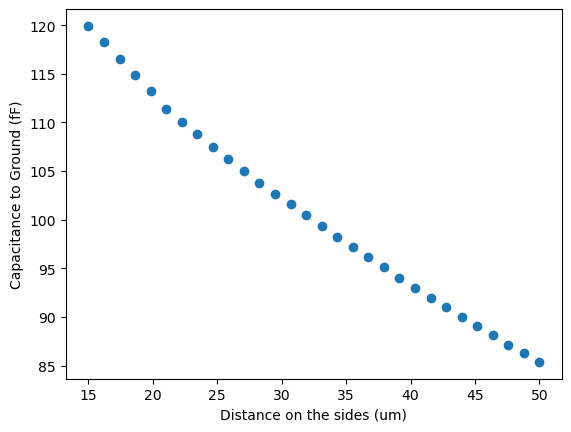

In [73]:
res  = []
for i in result:
    res += [i.value]
    
plt.figure()

plt.scatter(gaps.value, np.array(res))
plt.xlabel('Distance on the sides (um)')
plt.ylabel('Capacitance to Ground (fF)')
plt.show()

In [ ]:
stats.linregress(gaps.value)

In [67]:
def find_Cap_h(height):
    height = height.to(u.um)
    design.delete_all_components()

    options = dict(pad_width = '250um',
    pocket_width = '300um',
    pad_pocket_distance_top = '40um',
    pos_x = '0',
    pad_height = '{}um'.format(height.value),
    pos_y = '0',
    connection_pads = dict(
        a = dict(loc_W  = 1, 
                loc_H =  1, 
                pad_gap = '10um',
                pad_height = '20um',
                pad_width = '100um',
                pad_cpw_extent =  '10um',
                pocket_rise = '0um',
                cpw_extend = '5um')))

    q1 = TransmonPocket_Single(design,'Q1',options = options)

    gui.rebuild()
    gui.zoom_on_components(['Q1'])
    
    
    c1 = LOManalysis(design, "q3d")
    c1.sim.setup.min_passes  = 10
    c1.sim.setup.max_passes = 20
    
    c1.sim.run(components=['Q1'], open_terminations=[('Q1', 'a')])#, ('Q1', 'bus1'), ('Q1', 'bus2')])
    c1.sim.capacitance_matrix 

    c1.sim._get_results_from_renderer()
    c_mat = c1.sim.capacitance_matrix
    
    print(c_mat)
    
    return(c_mat)

In [68]:
heights = np.linspace(70*u.um, 240*u.um, 15)
result_height = []
for height in heights:
    result_height += [find_Cap_h(height)]

INFO 03:08PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 03:08PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 03:08PM [analyze]: Analyzing setup Setup


The plot below shows that if we make the pocket longer, where we also make the metal pad longer, then the capacitance increases

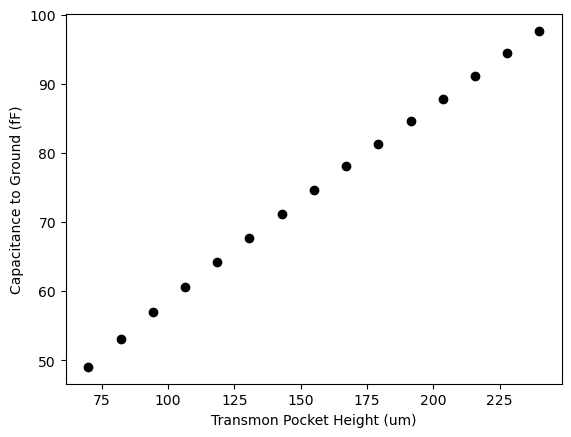

In [70]:
for i, r in enumerate(result_height):
    plt.scatter(heights[i], -r['pad_top_Q1']['ground_main_plane'],color = 'black')
plt.xlabel('Transmon Pocket Height (um)')
plt.ylabel('Capacitance to Ground (fF)')
plt.show()

### Function that takes in frequency and construct qubit design automatically

In [23]:
phi0 = c.h/2/c.e.si
T = 30*u.mK
epsilon_r = 11.7

In [69]:
def transmon_capacitance(Cq):
    Cq *= u.fF
    # Cq = 100*u.fF
    Lj = 12*u.nH
    Ec = (c.e.si**2/2/Cq).to(u.J)
    Ej = ((phi0/2/np.pi)**2/Lj).to(u.J)
    # epsilon1 = -Ec*2**9
    wq = (np.sqrt(8*Ej*Ec)-Ec)/c.hbar
    fq = wq/2/np.pi
    alpha = Ec/c.h
    
    return(fq)

In [70]:
def transmon_capacitance_optimzie(Cq, target_freq):
    Cq *= u.fF
    # Cq = 100*u.fF
    Lj = 12*u.nH
    Ec = (c.e.si**2/2/Cq).to(u.J)
    Ej = ((phi0/2/np.pi)**2/Lj).to(u.J)
    # epsilon1 = -Ec*2**9
    wq = (np.sqrt(8*Ej*Ec)-Ec)/c.hbar
    fq = wq/2/np.pi
    alpha = Ec/c.h
    
    return(fq-target_freq)

In [71]:
transmon_capacitance(120)

<Quantity 4.03268243e+09 1 / s>

In [61]:
target_freq = 4.5*u.GHz



target_cap = optimize.fsolve(transmon_capacitance_optimzie,100, args = (target_freq))[0]*u.fF


In [62]:
target_cap

<Quantity 87.40045862 fF>

In [25]:
def simulate_cap_minimize(width):
    return(find_Cap(width)-target_cap)

# width_45 = optimize.fsolve(simulate_cap_minimize, [250])

In [31]:
find_Cap(6*u.GHz)

UnitConversionError: 'GHz' (frequency) and 'um' (length) are not convertible

In [94]:
type(2*u.m)

astropy.units.quantity.Quantity

NameError: name 'width' is not defined

In [57]:
optimize.show_options()




minimize


bfgs
====

Minimization of scalar function of one or more variables using the
BFGS algorithm.

Options
-------
disp : bool
    Set to True to print convergence messages.
maxiter : int
    Maximum number of iterations to perform.
gtol : float
    Terminate successfully if gradient norm is less than `gtol`.
norm : float
    Order of norm (Inf is max, -Inf is min).
eps : float or ndarray
    If `jac is None` the absolute step size used for numerical
    approximation of the jacobian via forward differences.
return_all : bool, optional
    Set to True to return a list of the best solution at each of the
    iterations.
finite_diff_rel_step : None or array_like, optional
    If `jac in ['2-point', '3-point', 'cs']` the relative step size to
    use for numerical approximation of the jacobian. The absolute step
    size is computed as ``h = rel_step * sign(x) * max(1, abs(x))``,
    possibly adjusted to fit into the bounds. For ``method='3-point'``
    the sign of `h` is ignore